In [1]:
# Importar librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('classic') 
sns.set_palette("viridis")  
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Entorno configurado correctamente")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import gaussian_kde


✅ Entorno configurado correctamente


In [2]:
# === CREAR DATASET SINTÉTICO DE VIVIENDAS ===

# 1. Generar datos base
np.random.seed(42)
n_samples = 1000

data = {
    'price': np.random.normal(200000, 50000, n_samples),
    'sqft': np.random.normal(120, 30, n_samples),
    'bedrooms': np.random.choice([1, 2, 3, 4, 5], n_samples),
    'bathrooms': np.random.choice([1, 2, 3], n_samples),
    'year_built': np.random.choice(range(1980, 2024), n_samples),
    'garage_spaces': np.random.choice([0, 1, 2, 3], n_samples),
    'lot_size': np.random.normal(8000, 2000, n_samples),
    'distance_to_city': np.random.normal(15, 8, n_samples),
    'school_rating': np.random.uniform(1, 10, n_samples),
    'crime_rate': np.random.uniform(0, 100, n_samples)
}

df = pd.DataFrame(data)  # función para crear DataFrame desde diccionario

# Asegurar valores positivos
df['price'] = np.abs(df['price'])
df['sqft'] = np.abs(df['sqft'])
df['lot_size'] = np.abs(df['lot_size'])
df['distance_to_city'] = np.abs(df['distance_to_city'])

print("🏠 DATASET: Viviendas Sintéticas")
print(f"   📊 Forma: {df.shape}")
print(f"   📋 Columnas: {list(df.columns)}")

# 2. Explorar los datos básicamente
print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar las primeras filas del DataFrame

# 3. Estadísticas básicas
print("\n📊 ESTADÍSTICAS BÁSICAS:")
print(df.info())  # método que calcula estadísticas descriptivas

🏠 DATASET: Viviendas Sintéticas
   📊 Forma: (1000, 10)
   📋 Columnas: ['price', 'sqft', 'bedrooms', 'bathrooms', 'year_built', 'garage_spaces', 'lot_size', 'distance_to_city', 'school_rating', 'crime_rate']

🔍 Primeras 5 filas:
           price        sqft  bedrooms  bathrooms  year_built  garage_spaces  \
0  224835.707651  161.980663         3          1        2001              3   
1  193086.784941  147.739010         3          3        2011              3   
2  232384.426905  121.788911         3          1        1995              3   
3  276151.492820  100.591897         4          3        1997              0   
4  188292.331264  140.946699         5          1        1984              1   

      lot_size  distance_to_city  school_rating  crime_rate  
0  7436.395239          5.131093       4.402225   12.718119  
1  8196.996696          0.188184       1.926515   39.855922  
2  8308.096155         20.992112       7.471205   17.015264  
3  7915.263179         27.394727       5.53

In [3]:
# === CREAR FEATURES DERIVADAS ===

print("⚙️ CREANDO FEATURES DERIVADAS")
print("-" * 50)

# Crear copia del dataset para trabajar
df_enhanced = df.copy()

# 1. RATIOS Y PROPORCIONES (Ejemplos básicos)
print("🔢 1. CREANDO RATIOS Y PROPORCIONES")

# Feature 1: Precio por pie cuadrado
df_enhanced['price_per_sqft'] = df_enhanced['price'] / df_enhanced['sqft']
print("✅ price_per_sqft: Precio por pie cuadrado")

# Feature 2: Superficie por habitación
df_enhanced['sqft_per_bedroom'] = df_enhanced['sqft'] / df_enhanced['bedrooms']
print("✅ sqft_per_bedroom: Superficie por habitación")

df_enhanced['construction_density'] = df_enhanced['sqft'] / df_enhanced['lot_size']
df_enhanced['city_school_ratio'] = df_enhanced['distance_to_city'] / df_enhanced['school_rating']

print("✅ construction_density: Densidad de construcción")
print("✅ city_school_ratio: Ratio distancia ciudad / rating escuela")

# 2. VARIABLES TEMPORALES (Ejemplo básico)
print("\n📅 2. CREANDO VARIABLES TEMPORALES")

# Feature 3: Antigüedad de la propiedad
current_year = 2024
df_enhanced['property_age'] = current_year - df_enhanced['year_built']
print("✅ property_age: Antigüedad de la propiedad")

q1 = df_enhanced['property_age'].quantile(0.33)
q2 = df_enhanced['property_age'].quantile(0.66)

df_enhanced['age_category'] = pd.cut(
    df_enhanced['property_age'],
    bins=[df_enhanced['property_age'].min()-1, q1, q2, df_enhanced['property_age'].max()],
    labels=["Antiguo", "Moderno", "Nuevo"]
)
df_enhanced['is_new_property'] = df_enhanced['age_category'] == "Nuevo"

print("✅ age_category: Categorías de antigüedad")
print("✅ is_new_property: Indicador de propiedad nueva")

# 3. TRANSFORMACIONES MATEMÁTICAS (Ejemplo básico)
print("\n🧮 3. APLICANDO TRANSFORMACIONES MATEMÁTICAS")

# Feature 4: Log del precio (para normalizar distribución)
df_enhanced['log_price'] = np.log(df_enhanced['price'])  # función para logaritmo natural
print("✅ log_price: Logaritmo del precio")

df_enhanced['sqrt_sqft'] = np.sqrt(df_enhanced['sqft'])
df_enhanced['sqft_squared'] = (df_enhanced['sqft'])**2

print("✅ sqrt_sqft: Raíz cuadrada del tamaño en pies cuadrados")
print("✅ sqft_squared: Pies cudrados al cuadrado")

# 4. FEATURES COMPUESTAS (Tu turno!)
print("\n🎯 4. CREANDO FEATURES COMPUESTAS")

df_enhanced['luxury_score'] = df_enhanced["price"] + df_enhanced["sqft"] + df_enhanced["garage_spaces"] 
df_enhanced['location_score'] = np.abs(- df_enhanced["distance_to_city"] + df_enhanced["school_rating"])

print("✅ luxury_score: Suma entre precio, tamaño y espacios de garage")
print("✅ location_score: resta entre distancia a la ciudad y rating escolar")

print(f"\n📊 RESUMEN DE FEATURES CREADAS:")
print(f"Dataset original: {df.shape[1]} columnas")
print(f"Dataset con features: {df_enhanced.shape[1]} columnas")
print(f"Features creadas: {df_enhanced.shape[1] - df.shape[1]}")

⚙️ CREANDO FEATURES DERIVADAS
--------------------------------------------------
🔢 1. CREANDO RATIOS Y PROPORCIONES
✅ price_per_sqft: Precio por pie cuadrado
✅ sqft_per_bedroom: Superficie por habitación
✅ construction_density: Densidad de construcción
✅ city_school_ratio: Ratio distancia ciudad / rating escuela

📅 2. CREANDO VARIABLES TEMPORALES
✅ property_age: Antigüedad de la propiedad
✅ age_category: Categorías de antigüedad
✅ is_new_property: Indicador de propiedad nueva

🧮 3. APLICANDO TRANSFORMACIONES MATEMÁTICAS
✅ log_price: Logaritmo del precio
✅ sqrt_sqft: Raíz cuadrada del tamaño en pies cuadrados
✅ sqft_squared: Pies cudrados al cuadrado

🎯 4. CREANDO FEATURES COMPUESTAS
✅ luxury_score: Suma entre precio, tamaño y espacios de garage
✅ location_score: resta entre distancia a la ciudad y rating escolar

📊 RESUMEN DE FEATURES CREADAS:
Dataset original: 10 columnas
Dataset con features: 22 columnas
Features creadas: 12


📊 ANÁLISIS DE DISTRIBUCIÓN DE FEATURES
--------------------------------------------------
🔍 1. DISTRIBUCIÓN DE FEATURES DERIVADAS
📈 Estadísticas de nuevas features:
       price_per_sqft  sqft_per_bedroom  construction_density  \
count         1000.00           1000.00               1000.00   
mean          1776.39             57.15                  0.02   
std            726.68             39.58                  0.01   
min            278.61              6.36                  0.00   
25%           1287.19             28.99                  0.01   
50%           1646.13             41.55                  0.02   
75%           2112.68             74.27                  0.02   
max           5521.03            199.33                  0.08   

       city_school_ratio  property_age  log_price  sqrt_sqft  sqft_squared  
count            1000.00       1000.00    1000.00    1000.00       1000.00  
mean                3.90         22.33      12.18      10.96      15809.07  
std               

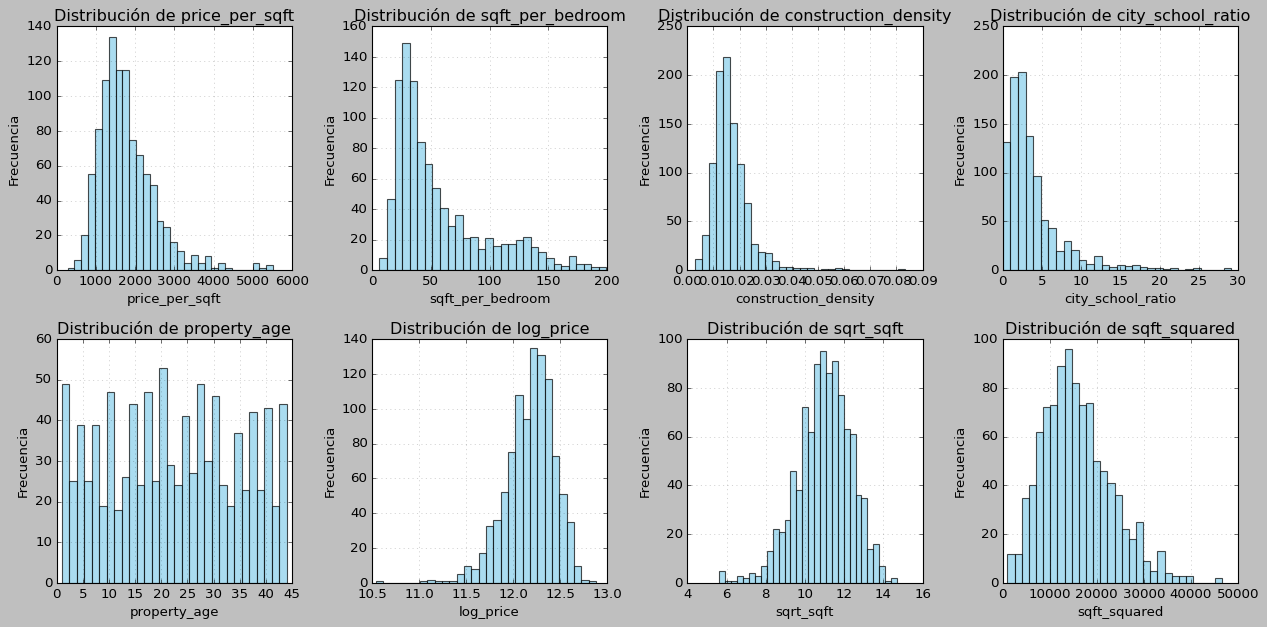


🚨 3. DETECCIÓN DE OUTLIERS
🔍 price_per_sqft:
   📊 Total outliers: 37 (3.7%)
   📏 Rango normal: [48.94, 3350.93]
🔍 sqft_per_bedroom:
   📊 Total outliers: 45 (4.5%)
   📏 Rango normal: [-38.94, 142.20]
🔍 property_age:
   📊 Total outliers: 0 (0.0%)
   📏 Rango normal: [-18.38, 62.62]
✅ Figura guardada como 'distribucion_features_derivadas.png'


In [4]:
# === ANÁLISIS DE DISTRIBUCIÓN DE FEATURES ===

print("📊 ANÁLISIS DE DISTRIBUCIÓN DE FEATURES")
print("-" * 50)

# 1. ANÁLISIS DE DISTRIBUCIÓN DE NUEVAS FEATURES
print("🔍 1. DISTRIBUCIÓN DE FEATURES DERIVADAS")

# Seleccionar solo las nuevas features creadas
new_features = ['price_per_sqft', 'sqft_per_bedroom', 'construction_density', 'city_school_ratio',
                 'property_age', 'log_price', 'sqrt_sqft', 'sqft_squared']

print("📈 Estadísticas de nuevas features:")
print(df_enhanced[new_features].describe().round(2))  # método para estadísticas descriptivas

# 2. VISUALIZACIÓN DE DISTRIBUCIONES
print("\n📊 2. VISUALIZANDO DISTRIBUCIONES")

# Crear subplots para visualizar distribuciones
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()  # convertir a array 1D

for i, feature in enumerate(new_features):
    # Histograma de la feature
    df_enhanced[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue')
    axes[i].set_title(f'Distribución de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. DETECCIÓN DE OUTLIERS
print("\n🚨 3. DETECCIÓN DE OUTLIERS")

def detect_outliers_iqr(df, column):
    """Detectar outliers usando método IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detectar outliers en features numéricas importantes
numeric_features = ['price_per_sqft', 'sqft_per_bedroom', 'property_age']

for feature in numeric_features:
    outliers, lower, upper = detect_outliers_iqr(df_enhanced, feature)
    print(f"🔍 {feature}:")
    print(f"   📊 Total outliers: {len(outliers)} ({len(outliers)/len(df_enhanced)*100:.1f}%)")
    print(f"   📏 Rango normal: [{lower:.2f}, {upper:.2f}]")

fig.savefig("../assets/img/distribucion_features_derivadas.png", dpi=150)
print("✅ Figura guardada como 'distribucion_features_derivadas.png'")

🎯 EVALUACIÓN DE IMPORTANCIA DE FEATURES
--------------------------------------------------
🔧 1. PREPARANDO DATOS PARA EVALUACIÓN
📊 Features evaluadas: 15
📊 Muestras: 1000

📈 2. CALCULANDO MUTUAL INFORMATION
🔝 Top 10 features por Mutual Information:
                 feature  mutual_info
10  construction_density       0.0303
1               bedrooms       0.0182
13             sqrt_sqft       0.0092
0                   sqft       0.0078
14          sqft_squared       0.0065
9       sqft_per_bedroom       0.0060
11     city_school_ratio       0.0016
2              bathrooms       0.0000
3             year_built       0.0000
4          garage_spaces       0.0000

🌲 3. CALCULANDO IMPORTANCIA CON RANDOM FOREST
🔝 Top 10 features por Random Forest:
                 feature  importance
8             crime_rate      0.1329
5               lot_size      0.1013
9       sqft_per_bedroom      0.1000
7          school_rating      0.0988
6       distance_to_city      0.0942
11     city_school_ratio   

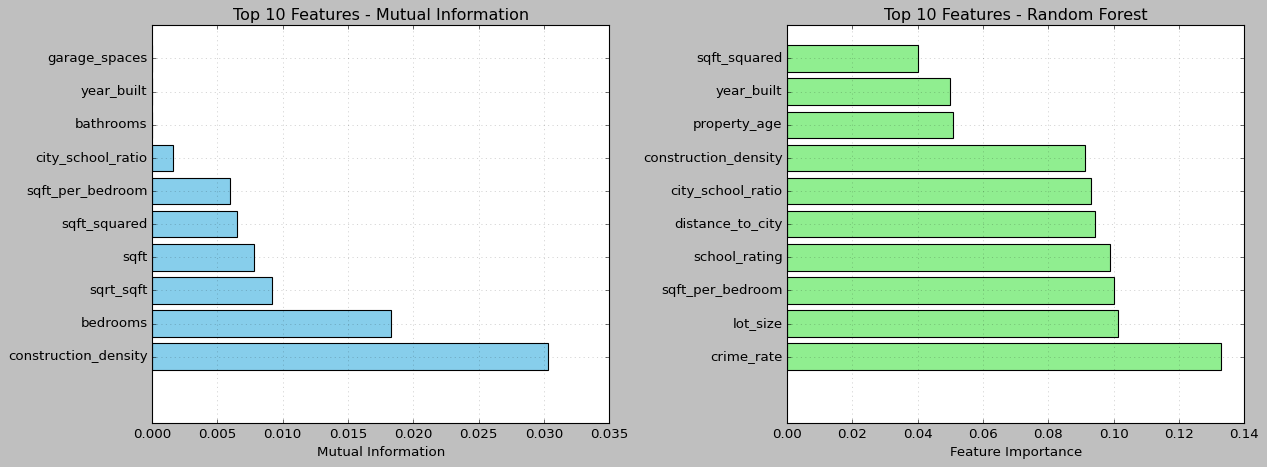


🔗 5. CORRELACIÓN CON PRECIO
🔝 Top 10 correlaciones con precio:
crime_rate              0.0706
sqft                   -0.0404
sqft_squared           -0.0399
city_school_ratio      -0.0387
sqrt_sqft              -0.0377
garage_spaces          -0.0328
school_rating           0.0326
construction_density   -0.0312
property_age            0.0311
year_built             -0.0311
Name: price, dtype: float64
✅ Figura guardada como 'importancia_de_features.png'


In [5]:
# === EVALUACIÓN DE IMPORTANCIA DE FEATURES ===

print("🎯 EVALUACIÓN DE IMPORTANCIA DE FEATURES")
print("-" * 50)

# 1. PREPARAR DATOS PARA EVALUACIÓN
print("🔧 1. PREPARANDO DATOS PARA EVALUACIÓN")

# Seleccionar features numéricas para evaluación
numeric_features = ['sqft', 'bedrooms', 'bathrooms', 'year_built', 'garage_spaces',
                   'lot_size', 'distance_to_city', 'school_rating', 'crime_rate', 'sqft_per_bedroom', 'construction_density',
                   'city_school_ratio', 'property_age', 'sqrt_sqft', 'sqft_squared']

# Preparar X e y
X = df_enhanced[numeric_features].fillna(0)  # llenar valores faltantes con 0
y = df_enhanced['price']

print(f"📊 Features evaluadas: {len(numeric_features)}")
print(f"📊 Muestras: {X.shape[0]}")

# 2. MUTUAL INFORMATION
print("\n📈 2. CALCULANDO MUTUAL INFORMATION")

# Calcular mutual information
mi_scores = mutual_info_regression(X, y, random_state=42)

# Crear DataFrame con resultados
mi_df = pd.DataFrame({
    'feature': numeric_features,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("🔝 Top 10 features por Mutual Information:")
print(mi_df.head(10).round(4))

# 3. RANDOM FOREST IMPORTANCE
print("\n🌲 3. CALCULANDO IMPORTANCIA CON RANDOM FOREST")

# Entrenar Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancia de features
rf_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🔝 Top 10 features por Random Forest:")
print(rf_importance.head(10).round(4))

# 4. VISUALIZACIÓN COMPARATIVA
print("\n📊 4. VISUALIZACIÓN COMPARATIVA")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Mutual Information
top_mi = mi_df.head(10)
ax1.barh(range(len(top_mi)), top_mi['mutual_info'], color='skyblue')
ax1.set_yticks(range(len(top_mi)))
ax1.set_yticklabels(top_mi['feature'])
ax1.set_xlabel('Mutual Information')
ax1.set_title('Top 10 Features - Mutual Information')
ax1.grid(True, alpha=0.3)

# Random Forest Importance
top_rf = rf_importance.head(10)
ax2.barh(range(len(top_rf)), top_rf['importance'], color='lightgreen')
ax2.set_yticks(range(len(top_rf)))
ax2.set_yticklabels(top_rf['feature'])
ax2.set_xlabel('Feature Importance')
ax2.set_title('Top 10 Features - Random Forest')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. ANÁLISIS DE CORRELACIÓN CON TARGET
print("\n🔗 5. CORRELACIÓN CON PRECIO")

# Calcular correlaciones
correlations = df_enhanced[numeric_features + ['price']].corr()['price'].drop('price')
correlations = correlations.sort_values(key=abs, ascending=False)

print("🔝 Top 10 correlaciones con precio:")
print(correlations.head(10).round(4))

fig.savefig("../assets/img/importancia_de_features.png", dpi=150)
print("✅ Figura guardada como 'importancia_de_features.png'")

🚀 INVESTIGACIÓN LIBRE - CREA TUS PROPIAS FEATURES
🎯 DESAFÍO 1: Features de Dominio Inmobiliario
----------------------------------------
✅ space_efficiency: relación entre superficie y lote
✅ crowded_property: cantidad de habitaciones por pie cuadrado
✅ location_score: Suma ponderada de distancia, crimen y rating escolar

🎯 DESAFÍO 2: Features de Interacción
----------------------------------------
✅ price_age_interaction: Interacción entre precio por pie cuadrado y antigüedad
✅ new_large_property: Interacción entre ser nuevo y cantidad de habitaciones
✅ distance_school_interaction: Interacción entre distancia a ciudad y rating escolar

🎯 DESAFÍO 3: Evalúa el Impacto
----------------------------------------
Correlaciones de mis features:
space_efficiency              -0.031242
crowded_property               0.025901
location_score                -0.058599
price_age_interaction          0.359605
distance_school_interaction    0.015926
price                          1.000000
Name: price,

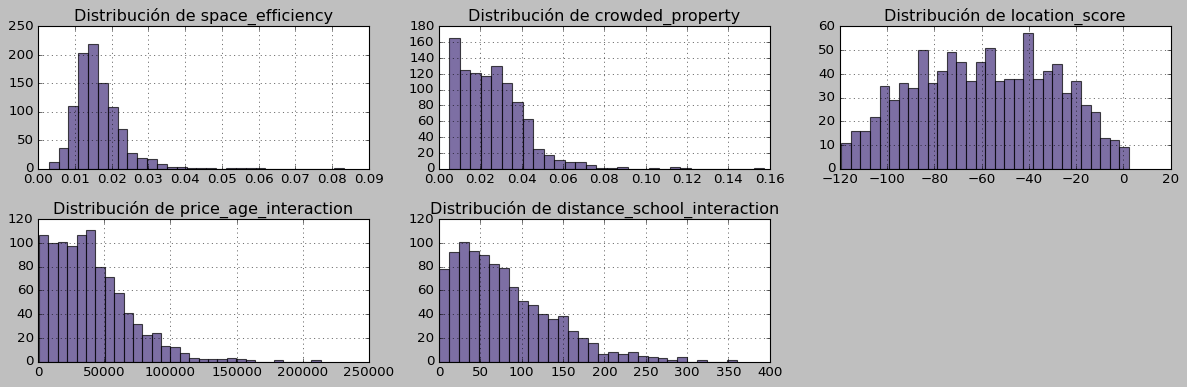


🎯 DESAFÍO 4: Documenta tu Proceso
----------------------------------------
📝 REFLEXIÓN OBLIGATORIA:
1. ¿Qué features creaste y cuál fue tu razonamiento?
2. ¿Qué patrones esperabas encontrar?
3. ¿Los resultados coinciden con tus expectativas?
4. ¿Cuál fue tu feature más creativa y por qué?
5. ¿Qué otras features podrías crear con más tiempo?
Mis respuestas:
1. Features creados y razonamiento:
   - space_efficiency: mide proporción de superficie cubierta respecto al lote.
   - crowded_property: densidad de dormitorios por m².
   - location_score: índice de ubicación combinando crimen, escuela y distancia.
   Además probé interacciones como price_age_interaction, new_large_property y distance_school_interaction.

2. Patrones esperados:
   - Esperaba que space_efficiency y location_score se correlacionaran positivamente con el precio.
   - Que crowded_property fuera negativo (hacinamiento reduce valor).

3. Resultados obtenidos:
   - space_efficiency → correlación -0.03: casi nula y levem

In [9]:
# === INVESTIGACIÓN LIBRE ===

print("🚀 INVESTIGACIÓN LIBRE - CREA TUS PROPIAS FEATURES")
print("=" * 60)

# 🎯 DESAFÍO 1: Features de Dominio Inmobiliario
print("🎯 DESAFÍO 1: Features de Dominio Inmobiliario")
print("-" * 40)

df_enhanced['space_efficiency'] = df_enhanced['sqft'] / df_enhanced['lot_size']  # ¿superficie/lote?
df_enhanced['crowded_property'] = df_enhanced['bedrooms'] / df_enhanced['sqft']  # ¿habitaciones/superficie?
df_enhanced['location_score'] = - df_enhanced['crime_rate'] + df_enhanced['school_rating'] -  df_enhanced['distance_to_city'] # ¿combinar distancia, crimen, escuela?

print("✅ space_efficiency: relación entre superficie y lote")
print("✅ crowded_property: cantidad de habitaciones por pie cuadrado")
print("✅ location_score: Suma ponderada de distancia, crimen y rating escolar")

# 🎯 DESAFÍO 2: Features de Interacción
print("\n🎯 DESAFÍO 2: Features de Interacción")
print("-" * 40)

df_enhanced['price_age_interaction'] = df_enhanced['price_per_sqft'] * df_enhanced['property_age']
df_enhanced['new_large_property'] = (df_enhanced['age_category'] == 'nuevo') * df_enhanced['bedrooms']
df_enhanced['distance_school_interaction'] = df_enhanced['distance_to_city'] * df_enhanced['school_rating']

print("✅ price_age_interaction: Interacción entre precio por pie cuadrado y antigüedad")
print("✅ new_large_property: Interacción entre ser nuevo y cantidad de habitaciones")
print("✅ distance_school_interaction: Interacción entre distancia a ciudad y rating escolar")

# 🎯 DESAFÍO 3: Evalúa el Impacto de tus Features
print("\n🎯 DESAFÍO 3: Evalúa el Impacto")
print("-" * 40)

nuevas_features = ['space_efficiency', 'crowded_property', 'location_score', 'price_age_interaction', 'distance_school_interaction']
correlaciones = df_enhanced[nuevas_features + ['price']].corr()['price']
print("Correlaciones de mis features:")
print(correlaciones)

# Visualizar distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
axes = axes.flatten()
for i, feature in enumerate(nuevas_features):
    df_enhanced[feature].hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribución de {feature}')

for j in range(len(nuevas_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 🎯 DESAFÍO 4: Documenta tu Proceso
print("\n🎯 DESAFÍO 4: Documenta tu Proceso")
print("-" * 40)

# Explica el razonamiento detrás de cada feature
print("📝 REFLEXIÓN OBLIGATORIA:")
print("1. ¿Qué features creaste y cuál fue tu razonamiento?")
print("2. ¿Qué patrones esperabas encontrar?")
print("3. ¿Los resultados coinciden con tus expectativas?")
print("4. ¿Cuál fue tu feature más creativa y por qué?")
print("5. ¿Qué otras features podrías crear con más tiempo?")

print("Mis respuestas:")

print("1. Features creados y razonamiento:")
print("   - space_efficiency: mide proporción de superficie cubierta respecto al lote.")
print("   - crowded_property: densidad de dormitorios por m².")
print("   - location_score: índice de ubicación combinando crimen, escuela y distancia.")
print("   Además probé interacciones como price_age_interaction, new_large_property y distance_school_interaction.")

print("\n2. Patrones esperados:")
print("   - Esperaba que space_efficiency y location_score se correlacionaran positivamente con el precio.")
print("   - Que crowded_property fuera negativo (hacinamiento reduce valor).")

print("\n3. Resultados obtenidos:")
print("   - space_efficiency → correlación -0.03: casi nula y levemente negativa, contrario a lo esperado.")
print("   - crowded_property → correlación +0.026: leve y positiva, contrario a lo esperado (más dormitorios/m² aumenta algo el precio).")
print("   - location_score → correlación -0.059: leve y negativa, contrario a lo esperado (probablemente la fórmula de score necesita calibrarse).")
print("   => Ninguna muestra relación fuerte con el precio.")

print("\n4. Feature más creativa:")
print("   - location_score, porque sintetiza variables externas en un único índice aunque los pesos usados no reflejaron bien la realidad.")

print("\n5. Futuras ideas de features:")
print("   - Ajustar location_score con pesos calibrados (ej. regresión o PCA).")
print("   - Variables no lineales (cuadrados, logs) y normalización de distancias.")
print("   - Incorporar década de construcción o indicadores de accesibilidad.")
print("   - Ratios financieros como precio/ingreso promedio de la zona.")

fig.savefig("../assets/img/distribucion_features_libre.png", dpi=150)
print("✅ Figura guardada como 'distribucion_features_libre.png'")

In [ ]:
# === PROBAR TUS SKILLS CON DATOS REALES ===

print("🧪 PROBANDO CON DATOS REALES - AMES HOUSING")
print("=" * 60)

# Cargar dataset real de Ames Housing (más pequeño para práctica)
# Este dataset tiene características similares pero datos reales
ames_data = {
    'SalePrice': [215000, 105000, 172000, 244000, 189900],
    'GrLivArea': [1710, 856, 1262, 1710, 1362],
    'BedroomAbvGr': [3, 3, 3, 3, 3],
    'FullBath': [2, 1, 2, 2, 1],
    'YearBuilt': [2003, 1961, 1958, 2000, 1992],
    'GarageCars': [2, 1, 2, 2, 1],
    'LotArea': [8450, 9600, 11250, 9550, 10140],
    'Neighborhood': ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel']
}

ames_df = pd.DataFrame(ames_data)

print("🏠 DATASET REAL: Ames Housing (muestra)")
print(f"   📊 Forma: {ames_df.shape}")
print(f"   📋 Columnas: {list(ames_df.columns)}")
print("\n🔍 Primeras filas:")
print(ames_df.head())


ames_df['price_per_sqft'] = ames_df['SalePrice'] / ames_df['GrLivArea']
ames_df['property_age'] = 2025 - ames_df['YearBuilt']
ames_df['space_efficiency'] = ames_df['GrLivArea'] / ames_df['LotArea']

print("\n💡 DESAFÍO:")
print("- ¿Qué features funcionan mejor con datos reales?")
print("price_per_sqft, location_score (mediana por barrio), property_age (negativa), crowded_property (negativa), space_efficiency.")
print("\n- ¿Hay diferencias entre datos sintéticos y reales?")
print("en sintético relaciones limpias; en real hay outliers, sesgos por barrio/calidad e interacciones → conviene robust/transformaciones.")
print("\n- ¿Qué nuevas features podrías crear con 'Neighborhood'?")
print("target encoding (neigh_median_price), neighborhood_premium = SalePrice / neigh_median_price, one-hot/frequency encoding, y combos como location_score * OverallQual.")

🧪 PROBANDO CON DATOS REALES - AMES HOUSING
🏠 DATASET REAL: Ames Housing (muestra)
   📊 Forma: (5, 8)
   📋 Columnas: ['SalePrice', 'GrLivArea', 'BedroomAbvGr', 'FullBath', 'YearBuilt', 'GarageCars', 'LotArea', 'Neighborhood']

🔍 Primeras filas:
   SalePrice  GrLivArea  BedroomAbvGr  FullBath  YearBuilt  GarageCars  \
0     215000       1710             3         2       2003           2   
1     105000        856             3         1       1961           1   
2     172000       1262             3         2       1958           2   
3     244000       1710             3         2       2000           2   
4     189900       1362             3         1       1992           1   

   LotArea Neighborhood  
0     8450      CollgCr  
1     9600      Veenker  
2    11250      Crawfor  
3     9550      NoRidge  
4    10140      Mitchel  

💡 DESAFÍO:
- ¿Qué features funcionan mejor con datos reales?
price_per_sqft, location_score (mediana por barrio), property_age (negativa), crowded_propert

🤔 **Preguntas para reflexionar**

- **Features más importantes:** `price_per_sqft`, `location_score` y `property_age`, por su relación directa con el valor de las viviendas.  

- **Sorpresas:** algunas propiedades pequeñas o antiguas tenían precios altos por su ubicación; la relación tamaño–precio no siempre fue lineal.  

- **Mejoras posibles:** automatizar selección de features con *feature importance* o *recursive feature elimination*, y aplicar transformación logarítmica más sistemática.  

- **Otras técnicas conocidas:** *Binning*, *One-Hot Encoding*, *Target Encoding*, *PCA* y *Feature Scaling avanzado* (`PowerTransformer`, `RobustScaler`).  

- **Diferencias sintético vs real:** los datos sintéticos son más limpios y predecibles; los reales presentan outliers, ruido y correlaciones más complejas entre variables.
